## Import Libraries

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Prepare the Dataset

In [23]:
# Init dataset and optimizer parameters
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [24]:
# Get the train data set and the test data set
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])),
                    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=False, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])),
                    batch_size=batch_size_test, shuffle=True)

In [25]:
# Test on some examples
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [26]:
# size : 28 * 28 grayscale pictures
example_data.shape

torch.Size([1000, 1, 28, 28])

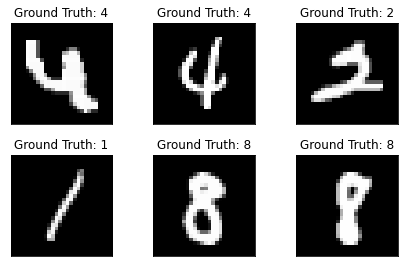

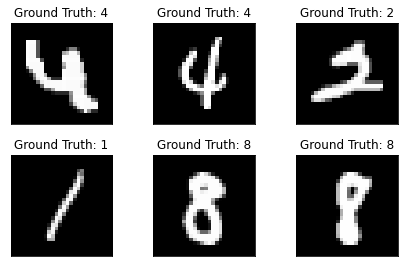

In [27]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

## Building the Network

In [28]:
class Encoder(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, in_channels*2, 5)
        self.conv2 = nn.Conv2d(in_channels*2, out_channels, 5)
        
        self.activation = nn.ReLU()
        
    def forward(self, x):

        x = self.conv1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.activation(x)

        return x

In [29]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_codewords, codewords_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self.num_codewords = num_codewords
        self.codewords_dim = codewords_dim
        self.codewords = nn.Parameter(torch.rand(self.num_codewords, self.codewords_dim),requires_grad=True)

        self.commitment_cost = commitment_cost
        
    def forward(self, inputs):
        # Reshape: B, C, H, W -> B*H*W, C
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        flat_inputs = inputs.view(-1, self.codewords_dim)

        # Calculating distances:
        distances = torch.pow(flat_inputs.unsqueeze(1) - self.codewords.unsqueeze(0),2).sum(2)

        # Argmin:
        encoding_indices = torch.argmin(distances, dim=1)

        # Index from dictionary:
        # quantized[i,j] = self.codewords[encoding_indices[i,j], j]
        quantized = torch.gather(self.codewords,0,encoding_indices.unsqueeze(1).expand(-1, self.codewords_dim)).view(inputs.shape)
        encoding_indices = encoding_indices.view(inputs.shape[:-1])

        # quantization loss
        quantizing_loss = F.mse_loss(quantized.detach(), inputs)
        commitment_loss = F.mse_loss(quantized, inputs.detach())
        loss = quantizing_loss + self.commitment_cost * commitment_loss

        # magic trick to copy gradients from inputs
        quantized = inputs + (quantized - inputs).detach()
        
        #Reshape:
        return quantized.permute(0, 3, 1, 2), encoding_indices, loss

In [30]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()

        self.conv1 = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=5)
        self.conv2 = nn.ConvTranspose2d(in_channels//2, out_channels, kernel_size=5)

        self.activation = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.activation(x)
        x = self.conv2(x)
        return x

In [31]:
class VQVAE(nn.Module):
    def __init__(self,x_dim,z_dim,num_codewords,commitment_cost):
        super().__init__()
        self.encoder = Encoder(x_dim,z_dim)
        self.quantizer = VectorQuantizer(num_codewords, z_dim, commitment_cost)
        self.decoder = Decoder(z_dim, x_dim)

    def forward(self, x):
        z_e = self.encoder(x)
        z_q, codes, q_loss = self.quantizer(z_e)
        x_hat = self.decoder(z_q)
        
        return x_hat, codes, q_loss

In [32]:
# Init network and optimizer
network = VQVAE(1,16,10,0.15).to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

## Training the Model

In [33]:
# Keep track of loss evolution for the train and the test dataset
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [34]:
# Def train loop
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output, codes, q_loss = network(data)
        
        #calcul loss
        rec_loss = F.mse_loss(output, data)
        loss = rec_loss + q_loss

        #backprop
        network.zero_grad()
        loss.backward()
        #optimizer.step()
        
        for f in (network.parameters()):
            f.data.sub_(f.grad.data * learning_rate)
            
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            #torch.save(network.state_dict(), '/results/model.pth')
            #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [35]:
# Training of the network
for epoch in range(1, n_epochs + 1):
    train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.429057
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.060568
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.911729
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.686411
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.774394
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.651119
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.626112
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.747566
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.601659
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.612499
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.553637
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.653186
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.514814
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.487951
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.490989
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.465163
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.417945
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.446631
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.406669
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.438152
Train Epoch: 1 [12800/60000 (